In this notebook, we're going to build multi-layer perceptron architecture

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
import random
random.seed(101)

### Loading Data

In [3]:
data = pd.read_csv('titanic_data.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# In the dataset, the column 'Survived' in binary.
# so we're making note of it here
dict_live = {
    0: 'Died',
    1: 'Survived'
}

# assigning numeric value to the unique values of 'Sex' in the dataset
dict_sex = {
    'male': 0, 
    'female':1
}

# creating a new column which adds the sex of the person as binary value
data['Bsex'] = data['Sex'].apply(lambda x:dict_sex[x])

# features
# these are the input features. then we convert this df to numpy array
features = data[['Pclass', 'Bsex']].to_numpy()
# these are the output features. then we convert this df to numpy array
labels = data['Survived'].to_numpy()

### Splittng The Data
* **test_size = 0.3** means 30% of our data will be the testing data
* **random_state** function controls the random number generator that shuffles data before splitting it. This parameter ensures that the same randomization is used each time the code is run, resulting in the same splits of the data

In [5]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(features, labels, test_size = 0.3, random_state = 0)

## Multi-Layer Perceptron

### Activation Function and Derivation

##### Sigmoid Function

In [6]:
# if derivative is set to True, it means
# we want it to return the derivative of 
# the sigmoid function and vice versa
def Sigmoid(x, derivative=False):
    if derivative:
        f = 1/(1 + np.exp(-x)) * (1-1/(1+np.exp(-x)))
    else:
        f = 1/(1 + np.exp(-x))
    
    return f
        

#### ReLu Function

In [7]:
def ReLu(x,  derivative=False):
    if derivative:
        # heaviside computes, for each value in x,
        # the function returns 0 for negative values of x,
        # 1 (2nd parameter we've set) for x = 0, 
        # and 1 for positive values of x.
        f = np.heaviside(x, 1)
    else:
        f = np.maximum(x, 0)
    return f

### Training Model

* **h1_units**: no of perceptrons in the 1st hidden layer default is set to 4
* **h2_units**: no of perceptrons in the 2nd hidden layer. default is set to 4
* **learning_rate**: is the alpha. 0.0015 seems like a good value
* **np.random.rand()** function creates an array of a specified shape and fills it with random values from a uniform distribution between 0 and 1. The number of weights

* **w1**: we want to create a matrix for w1. it will have h1_units of dimensions. and each dimension will have the size of the inputs. h1_units in this case is 4 and the number of inputs is 2 (Pclass and Bsex)
* **b1**: will have inputs-for-the-current-layer number of values. in this case it's 4
* **w2**: the size of this matrix will be, the number of inputs for the current layer multiplied by the number of ouputs from the pervious layer i.e., hidden_layer_1. so the shape will be, h2_units of rows and h1_units of columns

In [10]:
def train_ANN(xtrain, ytrain, h1_units=4, h2_units=4, learning_rate=0.0015):
    # so that we can get the same random values
    random.seed(101)
    
    # hidden layer 1
    w1 = 2 * np.random.rand(h1_units, xtrain.shape[1])
    b1 = np.random.rand(h1_units)
    
    # hidden layer 2
    w2 = 2 * np.random.rand(h2_units, h1_units)
    b2 = np.random.rand(h1_units)
    
    
    # output layer
    w_out = 2 * np.random.rand(h2_units)
    b_out = np.random.rand(1)
    
    loss = []
    vec_y = []
    
    for i in range(0, xtrain.shape[0]):
        x_data = xtrain[i]
        
        # 1. Feed Forward
        h1 = ReLu(np.dot(w1, x_data) + b1) # hidden layer 1 output
        h2 = ReLu(np.dot(w2, h1) + b2) # hidden layer 2 output
        y = Sigmoid(np.dot(w_out, h2) + b_out) # output of the output layer
    
        # 2. Backpropagate - calculate the layer derivatives
        delta_out = (y - ytrain[i]) * Sigmoid(y, derivative=True)
        delta_2 = delta_out * w_out * ReLu(h2, derivative=True)
        delta_1 = np.dot(delta_2, w2) * ReLu(h1, derivative=True) 
        
        # 3. Gradient Descent
        w_out -= learning_rate * delta_out * h2 # output layer
        b_out -= learning_rate * delta_out
        
        # hidden layer2
        w2 -= learning_rate * np.kron(delta_2, h1).reshape(h2_units, h1_units)
        b2 -= learning_rate * delta_2
        
        # hidden layer 1
        w1 -= learning_rate * np.kron(delta_1, x_data).reshape(h1_units, x_data.shape[0])
        b1 -= learning_rate * delta_1
        
        # cost
        loss.append((1/2) * (y-ytrain[i]) ** 2)
         
        vec_y.append(y[0])
        
    batch_loss = []
    for i in range(0, 10):
        loss_avg = 0
        for m in range(0, 60):
            loss_avg += vec_y[60*i + m] / 60
        batch_loss.append(loss_avg)
    
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, len(batch_loss) + 1), batch_loss)
    plt.title('Average Loss by epoch', fontsize=20)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.show()
    
    return w1, b1, w2, b2, w_out, b_out, loss
    
        
        

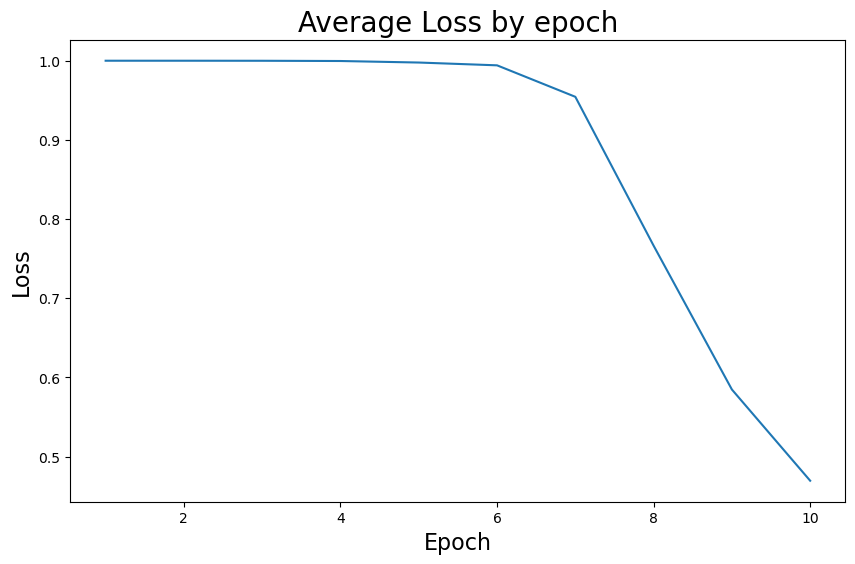

In [11]:
w1, b1, w2, b2, w_out, b_out, loss = train_ANN(xtrain, ytrain)

### Testing the Model

In [14]:
def ANN_pred(xtest, w1, b1, w2, b2, w_out, b_out):
    
    pred = []
    
    for i in range(0, xtest.shape[0]):
        
        x = xtest[i]
        
        z1 = ReLu(np.dot(w1, x) + b1) # hidden layer 1 output
        z2 = ReLu(np.dot(w2, z1) + b2) # HL2 houtput
        y = Sigmoid(np.dot(w_out, z2) + b_out) # output of the output layer
        
        pred.append(np.heaviside(y-0.5, 1)[0])
        
    return np.array(pred)
        

In [15]:
predictions = ANN_pred(xtest, w1, b1, w2, b2, w_out, b_out)
predictions

array([0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       1., 1., 0., 1., 0.

### Model Evaluation

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix

cm = confusion_matrix(ytest, predictions)

ind_names = [dict_live[i] for i in range(0, 2)]
cm_df = pd.DataFrame(cm, index = ind_names, columns = ind_names)

In [20]:
cm_df

,Died,Survived
Died,140,28
Survived,29,71


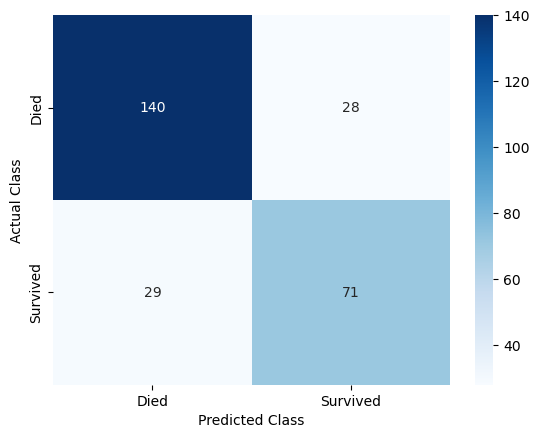

In [21]:
sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [25]:
score = accuracy_score(ytest, predictions)
print(f"Your model is: {round(score * 100, 1)}% accurate")

Your model is: 78.7% accurate
